# PS 3
Maximilian Huber

This code is stored at: https://github.com/MaximilianJHuber/NYU/blob/master/EmpIO/PS3.ipynb.
## Part 1
The package StatsFuns implements such a function:

In [76]:
using StatsFuns
using StatsBase
using Parameters
using Optim
using Plots; pyplot()

Plots.PyPlotBackend()

In [77]:
@less logsumexp([1., 2.]) 

# common facilities

# scalar functions

xlogx(x::Real) = x > zero(x) ? x * log(x) : zero(log(x))

xlogy{T<:Real}(x::T, y::T) = x > zero(T) ? x * log(y) : zero(log(x))
xlogy(x::Real, y::Real) = xlogy(promote(x, y)...)

# logistic: 1 / (1 + exp(-x))
#
logistic(x::Real) = one(x) / (one(x) + exp(-x))

# logit: log(x / (1 - x))
#
logit(x::Real) = log(x / (one(x) - x))

# log1psq: log(1+x^2)
#
log1psq(x::Real) = log1p(abs2(x))
log1psq(x::Union{Float32,Float64}) = (ax = abs(x); ax < maxintfloat(x) ? log1p(abs2(ax)) : 2 * log(ax))

# log1pexp: log(1+exp(x))
#
log1pexp(x::Real) = x < 18.0 ? log1p(exp(x)) : x < 33.3 ? x + exp(-x) : oftype(exp(-x), x)
log1pexp(x::Float32) = x < 9.0f0 ? log1p(exp(x)) : x < 16.0f0 ? x + exp(-x) : oftype(exp(-x), x)

# log1mexp: log(1 - exp(x))
#
# See:
#   Martin Maechler (2012) "Accurately Computing log(1 − exp(− |a|))"
#   http://cran.r-project.org/web/packages/Rmpfr/vignettes/log1mexp-note.pdf
#
# Note: different than Maechler (2012), no negation inside paranth

In [78]:
using DataFrames
using BasisMatrices

data = readtable("rustdata1.csv", header=true, separator=',')
head(data)

,ID,x_t,d_t
1,1,0.0,0
2,2,0.09675,0
3,3,1.1574,0
4,4,3.1956,0
5,5,4.9654,1
6,6,0.72995,0


The Rust (1987) problem is:
$$\log\mathcal{L} = \sum_t^{T}\log\mathbb{P}\left.\Big[i_t \,\middle|\, x_t\Big]\right.$$
where $\theta = [\theta_c, RC]$ and $\theta_p$ is estimated outside of the ML estimation.


The expected continuation value given today's mileage and replacement decision, $EV\Big(x_t, i_t\Big)$, can be found solving for a fixed point, see (4.14) from Rust (1987):

$$EV\Big(x_t, i_t\Big) = \int \log\Big(\sum_{i'=0,1}\exp\Big(u(x',i') + \beta \cdot EV\Big(x', i'\Big)\Big)\Big) p(x'|\theta_p, x_t, i_t)$$

With $EV\Big(x_t, i_t\Big)$, I can find:
$$\tilde{V}\Big(x_t, i_t\Big)=\left\{\begin{matrix}
-c(0) -RC + \beta EV\Big(x_t, 1\Big) & \text{if } i_t = 1 \\ 
-c(x_t) + \beta EV\Big(x_t, 0\Big) & \text{if } i_t = 0
\end{matrix}\right.$$
And using (4.13) from Rust (1987):
$$\mathbb{P}\left.\Big[i_t \,\middle|\, x_t\Big]\right. = \frac{\exp\Big(\tilde{V}\Big(x_t, i_t\Big)\Big)}{\exp\Big(\tilde{V}\Big(x_t, 0\Big)\Big)+\exp\Big(\tilde{V}\Big(x_t, 1\Big)\Big)}$$
This probability takes $\theta_c$, $RC$, $\beta$ and $\theta_p$ as given.

The derivatives are:
$$\frac{\partial \log\mathbb{P}}{\partial \theta} = \frac{1}{\mathbb{P}}\frac{\partial \mathbb{P}}{\partial \theta}$$
$$\frac{\partial \mathbb{P}}{\partial \theta}\Big[x_t, i_t\Big] = \frac{\exp\Big(\tilde{V}\Big(x_t, 0\Big)+\tilde{V}\Big(x_t, 1\Big)\Big)}{\Big(\exp\Big(\tilde{V}\Big(x_t, 0\Big)\Big)+\exp\Big(\tilde{V}\Big(x_t, 1\Big)\Big)\Big)^2}\Big(\frac{\partial \tilde{V}}{\partial \theta}\Big(x_t, i_t\Big)\Big)-\frac{\partial \tilde{V}}{\partial \theta}\Big(x_t, 1-i_t\Big)\Big)\Big)$$

We could use the implicit function theorem to get the derivative of $EV$, but this will lead to a 200-row linear system of equations with one $dEV$ on the left-hand-side and ten $dEV$s on the right each. That I could solve to get $\frac{\partial EV}{\partial \theta_c}$.

I am not going to do this. I solve the MPEC first and get a good guess for the NFXP and use Nelder-Mead (needs no derivative).

## Part 2
### 1.
I collect all the not ML estimated values into a type. I take the first difference of mileage data and throw out all negative entries to find $\theta_p$:

In [79]:
@with_kw mutable struct RustModel
    # deep model parameters
    θp::Vector{Float64}
    β::Float64
    
    # book-keeping
    breaks::Vector{Float64}
    grid_size::Int64
    grid::Vector{Float64}
    y::Vector{Float64}                 #possible increments in mileage
    basis::BasisMatrices.Basis{1,Tuple{BasisMatrices.LinParams{Array{Float64,1}}}}
    EV0::Vector{Float64}
    EV1::Vector{Float64}

    x::Vector{Float64}
    i::Vector{Int64}
end

function RustModel(data::DataFrame)
    
    breaks = [0, 0.5, 1, 1.5, 2, 3]
    changes = diff(data[:x_t])[diff(data[:x_t]) .> 0]
    θp = [sum(breaks[i] .<= changes .< breaks[i+1]) for i in 1:length(breaks)-1]/length(changes)
    
    grid_size = 100
    grid = collect(linspace(0, 15, grid_size))     #the grid is big enough for all the observations!
    y = (breaks[2:end] .+ breaks[1:end-1])/2       #I take the midpoints of the intervals, 
                                                   #i.e. I assume uniform distribution within an interval
    basis = Basis(LinParams(grid, 0))
    
    return RustModel(θp, 0.975, breaks, grid_size, grid, y, basis, zeros(grid_size), zeros(grid_size), convert(Array{Float64}, data[:x_t]), convert(Array{Int64}, data[:d_t]))
end

RustModel

In [80]:
model = RustModel(data)

RustModel
  θp: Array{Float64}((5,)) [0.256868, 0.245879, 0.229396, 0.195055, 0.0728022]
  β: Float64 0.975
  breaks: Array{Float64}((6,)) [0.0, 0.5, 1.0, 1.5, 2.0, 3.0]
  grid_size: Int64 100
  grid: Array{Float64}((100,)) [0.0, 0.151515, 0.30303, 0.454545, 0.606061, 0.757576, 0.909091, 1.06061, 1.21212, 1.36364  …  13.6364, 13.7879, 13.9394, 14.0909, 14.2424, 14.3939, 14.5455, 14.697, 14.8485, 15.0]
  y: Array{Float64}((5,)) [0.25, 0.75, 1.25, 1.75, 2.5]
  basis: BasisMatrices.Basis{1,Tuple{BasisMatrices.LinParams{Array{Float64,1}}}}
  EV0: Array{Float64}((100,)) [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
  EV1: Array{Float64}((100,)) [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
  x: Array{Float64}((1000,)) [0.0, 0.09675, 1.1574, 3.1956, 4.9654, 0.72995, 1.0019, 2.7135, 3.0876, 4.915  …  1.2539, 0.68476, 0.81895, 2.4645, 3.3241, 3.3862, 0.93309, 1.7654, 0.99437, 0.7

## NFXP

### 2.


In [81]:
function c(x, θc)
    θc[1] .* x + θc[2] .* x.^2
end

c (generic function with 1 method)

In [82]:
#todo newton
function solve_fp!(θc, RC, model::RustModel)
    @unpack θp, β, breaks, grid_size, grid, y, basis, EV0, EV1, x, i = model
    
    Ψ = BasisMatrix(basis, Expanded(), (grid .+ y')[:]).vals[1]
    Φ = BasisMatrix(basis, Expanded(), (zeros(grid_size,length(y)) .+ y')[:]).vals[1]

    oldEV0 = similar(EV0)
    oldEV1 = similar(EV1)
    error = 1.

    while error > 1e-12

        oldEV0 = copy(EV0)
        oldEV1 = copy(EV1)

        # no replace
        EV0 = logsumexp.(-c(grid .+ y', θc) .+ β .* reshape(Ψ * oldEV0, grid_size, length(y)), 
            zeros(grid_size,length(y)) - RC .+ β .* reshape(Ψ * oldEV1, grid_size, length(y))
            ) * θp

        # replace
        EV1 = logsumexp.(-c(zeros(grid_size,length(y)) .+ y', θc) .+ β .* reshape(Φ * oldEV0, grid_size, length(y)), 
            zeros(grid_size,length(y)) - RC .+ β .* reshape(Φ * oldEV1, grid_size, length(y))
            ) * θp

        error = maximum(abs.(vcat(EV0, EV1) .- vcat(oldEV0, oldEV1)))
    end
    
    model.EV0 = EV0
    model.EV1 = EV1
    
    return nothing
end

solve_fp!([1., 1/2], 100., RustModel(data));

In [83]:
@time solve_fp!([1., 1/2], 10., model);

  0.109371 seconds (46.45 k allocations: 107.239 MiB, 22.36% gc time)


### 3.
I compute the CCP as in (4.13) from Rust (1987):

In [84]:
function V(x::Vector{Float64}, i::Vector{Int64}, θc, RC, model::RustModel)
    ifelse.(i .== 1, 
        0 - RC + model.β * BasisMatrix(model.basis, Expanded(), x).vals[1] * model.EV1,
        -c(x, θc) + model.β * BasisMatrix(model.basis, Expanded(), x).vals[1] * model.EV0)
end

V (generic function with 1 method)

In [85]:
function P(θc, RC, model::RustModel)
    exp.(V(model.x, model.i, θc, RC, model)) ./
        (exp.(V(model.x, zeros(Int64, length(model.x)), θc, RC, model)) .+ 
        exp.(V(model.x, ones(Int64, length(model.x)), θc, RC, model)))
end

P (generic function with 1 method)

In [86]:
function L(θ, model::RustModel)
    
    θc = θ[1:2]
    RC = θ[3]
    
    solve_fp!(θc, RC, model)
    
    sum(log.(P(θc, RC, model)))
end

L (generic function with 1 method)

Let me start with a good guess (that actually came from the MPEC, because it worked better):

In [87]:
objective(θ) = -L(θ, model)
objective([0.05, 0.001, 1.])
@time result = optimize(objective, [0.05, 0.001, 1.], NelderMead())

 12.796324 seconds (4.90 M allocations: 11.144 GiB, 20.76% gc time)


Results of Optimization Algorithm
 * Algorithm: Nelder-Mead
 * Starting Point: [0.05,0.001,1.0]
 * Minimizer: [0.05455101880466138,0.0013391222716874073, ...]
 * Minimum: 6.237264e+02
 * Iterations: 72
 * Convergence: true
   *  √(Σ(yᵢ-ȳ)²)/n < 1.0e-08: true
   * Reached Maximum Number of Iterations: false
 * Objective Calls: 144

In [88]:
NFXPθ = result.minimizer

3-element Array{Float64,1}:
 0.054551  
 0.00133912
 1.15173   

In [89]:
solve_fp!(NFXPθ[1:2], NFXPθ[3], model)
NFXPEV = hcat(model.EV0, model.EV1)

100×2 Array{Float64,2}:
 5.81879  5.81879
 5.80089  5.81879
 5.7832   5.81879
 5.76574  5.81879
 5.7485   5.81879
 5.73147  5.81879
 5.71466  5.81879
 5.69806  5.81879
 5.68167  5.81879
 5.66548  5.81879
 5.6495   5.81879
 5.63372  5.81879
 5.61814  5.81879
 ⋮               
 4.87194  5.81879
 4.8663   5.81879
 4.86073  5.81879
 4.85523  5.81879
 4.8498   5.81879
 4.84444  5.81879
 4.83914  5.81879
 4.8339   5.81879
 4.82873  5.81879
 4.82361  5.81879
 4.81856  5.81879
 4.81356  5.81879

## MPEC
The MPEC formulation of the problem is done in JuMP, I use IpOpt as solver:

In [90]:
using JuMP
using Ipopt

In [91]:
@unpack θp, β, breaks, grid_size, grid, y, basis, EV0, EV1, x, i = model

m = Model(solver=IpoptSolver(print_level=5));

I have three kinds of variables:

In [92]:
@variable(m, θc[1:2] >= 0, start = 1)

2-element Array{JuMP.Variable,1}:
 θc[1]
 θc[2]

In [93]:
@variable(m, RC >= 0, start = 10)

RC

In [94]:
@variable(m, EV[1:grid_size, 0:1])

EV[i,j] ∀ i ∈ {1,2,…,99,100}, j ∈ {0,1}

I code up the probability of every observation $j$ by linearly interpolating between the closest elements of $EV$. The grid for the $x$-axis has been chosen, such that all observations lie in the interior.

In [95]:
right = zeros(Int64, length(x))
left = zeros(Int64, length(x))
rightweight = zeros(length(x))

for k in 2:length(x)
    right[k] = findfirst(x[k] - grid .<= 0)
    left[k] = right[k] - 1
    rightweight[k] = (x[k] - grid[left[k]])/(grid[right[k]] - grid[left[k]])
end

ProbExpr = @NLexpression(m, Prob[k=2:length(x)], exp(ifelse(i[k] == 0, -θc[1]*x[k] -θc[2]*x[k]^2, 0 - RC) + 
        β * ((1-rightweight[k]) * EV[left[k], i[k]] + rightweight[k] * EV[right[k], i[k]])) / (
        exp(-θc[1]*x[k] -θc[2]*x[k]^2 + β * ((1-rightweight[k]) * EV[left[k], 0] + rightweight[k] * EV[right[k], 0])) + 
        exp(0 - RC + β * ((1-rightweight[k]) * EV[left[k], 1] + rightweight[k] * EV[right[k], 1]))
        ));

Now I figure out the integrand of the $EV$-fixed-point equation. In my notation: $x' = x + y$, where $y$ is one of the possible increments:

In [96]:
xprime = zeros(grid_size, length(y), 2)
right = zeros(Int64, grid_size, length(y), 2)
left = zeros(Int64, grid_size, length(y), 2)
rightweight = zeros(grid_size, length(y), 2)

for j in 1:grid_size #x_t
    for k in 1:length(y) #y
        for i in 1:2 #i_t
            if i == 1
                xprime[j, k, i] = grid[j] + y[k] #no replace
                else 
                xprime[j, k, i] = y[k] #replace
            end
            
            right[j, k, i] = findfirst(xprime[j, k, i] - grid .<= 0)
            
            if right[j, k, i] == 0 # if "findfirst" finds nothing, i.e. we fall off the grid on the right!
                right[j, k, i] = grid_size # set to the most right grid point
                left[j, k, i] = grid_size - 1
                rightweight[j, k, i] = 1
            else 
                left[j, k, i] = right[j, k, i] - 1
                rightweight[j, k, i] = (xprime[j, k, i] - grid[left[j, k, i]])/(grid[right[j, k, i]] - grid[left[j, k, i]])
            end
        end
    end
end

I have to register my $logsumexp$-function in order to have it automatically differentiated:

In [97]:
function mylogsumexp(x, y)
    u = max(x, y)
    log(exp(x - u) + exp(y - u)) + u
end

JuMP.register(m, :mylogsumexp, 2, mylogsumexp, autodiff=true)

@NLexpression(m, integrand[j=1:grid_size, i=0:1, k=1:length(y)], mylogsumexp(
                    -θc[1]*xprime[j, k, i+1] -θc[2]*xprime[j, k, i+1]^2 + β * ((1-rightweight[j, k, i+1]) * 
                        EV[left[j, k, i+1], 0] + rightweight[j, k, i+1] * EV[right[j, k, i+1], 0]), 
                    -RC + β * ((1-rightweight[j, k, i+1]) * 
                        EV[left[j, k, i+1], 1] + rightweight[j, k, i+1] * EV[right[j, k, i+1], 1])
                        ));

In [98]:
@NLconstraint(m, integralconstraint[j=1:grid_size, i=0:1], EV[j, i] == sum(integrand[j, i, k] * θp[k] for k in 1:length(y)))

@NLobjective(m, Max, sum(log(Prob[k]) for k in 2:length(x)))

It could make sense to set the initial value of $EV$ to be feasible. It is not necessary in this application, but is a bit faster:

In [99]:
solve_fp!(getvalue(θc), getvalue(RC), model)
for j in 1:grid_size
    setvalue(EV[j, 0], model.EV0[j])
    setvalue(EV[j, 1], model.EV1[j])
end

In [100]:
solve(m)

This is Ipopt version 3.12.1, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     4652
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      203
                     variables with only lower bounds:        3
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      200
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

:Optimal

The solution is found!

In [101]:
MPECθ = vcat(getvalue(θc), getvalue(RC))

3-element Array{Float64,1}:
 0.0523134 
 0.00153601
 1.14394   

In [102]:
MPECEV = hcat([getvalue(EV)[:, i] for i in 0:1]...);

No matter where we are on the grid, replacing has the same value as starting with an engine with zero mileage.

Let me get the functions back from the solver:

In [31]:
d = JuMP.NLPEvaluator(m)
MathProgBase.initialize(d, [:Grad, :Jac])

In [32]:
optimizer = vcat(MPECθ, MPECEV'[:]);

In [33]:
@time f = MathProgBase.eval_f(d, optimizer)

  0.000037 seconds (11 allocations: 304 bytes)


-623.4517996742125

In [34]:
g = zeros(200)
@time MathProgBase.eval_g(d, g, optimizer)
maximum(g)

  0.000042 seconds (10 allocations: 288 bytes)


-7.65707497407675e-11

The constraints are fullfilled!

## Comparison

In [120]:
table = DataFrame()
table[:Method] = ["NFXP", "MPEC"]; table[:θc1] = round.([NFXPθ[1], MPECθ[1]], 4);
table[:θc2] = round.([NFXPθ[2], MPECθ[2]], 4);
table[:RC] = round.([NFXPθ[3], MPECθ[3]], 4);

table

,Method,θc1,θc2,RC
1,NFXP,0.0546,0.0013,1.1517
2,MPEC,0.0523,0.0015,1.1439



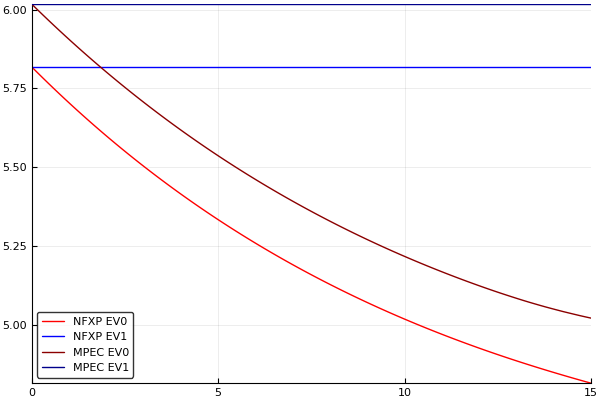

In [113]:
plot(grid, NFXPEV, label=["NFXP EV0" "NFXP EV1"], color=["red" "blue"])
plot!(grid, MPECEV, label=["MPEC EV0" "MPEC EV1"], color=["darkred" "darkblue"])

Quite close, but maybe there is a small error in my program!